In [1]:
# a couple plotting conveniences...
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import datetime
import getpass

import cx_Oracle

class DbOra:
    
    connstr = '{username}/{password}@{hostname}:{port}/{database}'
#     oracle_connection_string = 'oracle+cx_oracle://' + \
#         '{username}:{password}@{hostname}:{port}/{database}'

    def __init__(self, username, password, hostname, sid, port=1521):
        self._username = username
        self._hostname = hostname
        self._sid = sid
        self._port = port
        self._connection = cx_Oracle.connect(
            DbOra.connstr.format(
                username=username,
                password=password,
                hostname=hostname,
                port=port,
                database=sid
            )
        )
        self._cursor = self._connection.cursor()
        self._cursor.arraysize = 50000
        
    @property
    def cursor(self):
        return self._cursor
    
    def stage_data(self, name, cnames, data):
        map_dtype_to_oratype = {
            str: 'VARCHAR2(256)',
            int: 'NUMBER',
            float: 'NUMBER',
            datetime.datetime: 'DATE'
        }
        ora_types = [map_dtype_to_oratype[type(x)] for x in data[0]]
        cols_str = ', '.join(['%s %s'%(cname, oratype)
                             for cname, oratype in zip(cnames, ora_types)])
        sql_create = 'create global temporary table %s (%s) on commit preserve rows'%(name, cols_str)
#         sql_create = 'create table %s (%s)'%(name, cols_str)
        
        ncols = len(data[0])
        bind_vars_str = ', '.join([':%d'%(i+1) for i in range(ncols)])
        sql_load = 'insert into %s (%s) values (%s)'%(name, ', '.join(list(cnames)), bind_vars_str)
        try:
            self._cursor.execute(sql_create)
        except cx_Oracle.DatabaseError as dberr:
            error, = dberr.args
            if error.code == 955:
                pass
            else:
                raise
        self._cursor.prepare(sql_load)
        self._cursor.executemany(None, data)
        
    def execute(self, sql):
        self._cursor.execute(sql)
            
    def query(self, sql):
        self._cursor.execute(sql)
        for rec in self._cursor:
            yield rec
            
    def get_column_names(self):
        return [x[0] for x in self._cursor.description]
        
    def commit(self):
        self._connection.commit()
        
    def rollback(self):
        self._connection.rollback()

    def __del__(self):
        self._connection.rollback()
        self._connection.close()

In [41]:
# these are expected to be in the current working directory
from throttle import *   # throttle decorator to limit frequency of wrapped function calls

# other imports
import pandas as pd
import functools
import pickle
import requests

#Test throttle decorator
F = 20
N = 20
F_throttled = measure_throttle(n=N, per_sec=F)
res_str = 'Throttle Test:\t%%s (%.3f calls per second)'%F_throttled
if F_throttled < F and F_throttled > 0.9*F:
    print(res_str%'PASS')
else:
    print(res_str%'FAIL')


def cached(func):
    func.cache = {}
    try:
        func.cache = pickle.load(open('%s.cache.pickle'%func.__name__, 'rb'))
    except FileNotFoundError:
        pass

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        key = (args, frozenset(kwargs.items()))
        try:
            return func.cache[key]
        except KeyError:
            func.cache[key] = result = func(*args, **kwargs)
            return result   
    return wrapper


@throttle(per_sec=20)
@cached
def rxnorm_req(resource, **kwargs):
    is_json = True
    if 'rxnorm_base' not in kwargs:
         kwargs['rxnorm_base'] = 'https://rxnav.nlm.nih.gov/REST/'
    if 'json' in kwargs:
        is_json = kwargs['json']
    if is_json:
        resource += '.json'
    
    attrs = ['%s=%s'%(attr,val) for (attr,val) in
             kwargs.items() if attr != 'rxnorm_base']
    
    req = kwargs['rxnorm_base'] + resource + '?%s'%('&'.join(attrs))
    
    resp = requests.get(req)
    return resp.json() if is_json else resp


def coerce_rxcui(rxcui):
    json = rxnorm_req('rxcui/%s/status'%rxcui)
    status = json['rxcuiStatus']['status']
    
    if status in ('Retired', 'Unknown', 'Alien'):
        #warning('Cannot coerce! status = %s'%status)
        return None
    
    retval = json['rxcuiStatus']['minConceptGroup']['minConcept'][0]['rxcui']
    return retval


def get_status(rxcui):
    json = rxnorm_req('rxcui/%s/status'%rxcui)
    status = json['rxcuiStatus']['status']
    return status


def get_TTY(rxcui):
    json = rxnorm_req('rxcui/%s/property'%rxcui, propName='TTY')
    cgroup = json['propConceptGroup']
    if cgroup is None:
        return ''
    return cgroup['propConcept'][0]['propValue']


def get_props(rxcui, skip_coerce=False):
    json = rxnorm_req('rxcui/%s/properties'%rxcui)
    key = 'properties'
    props = None
    if json is None:
        if skip_coerce == False:
            rxcui_new = coerce_rxcui(rxcui)
            if rxcui_new is not None:
                props = get_props(coerce_rxcui(rxcui),
                                  skip_coerce=True)
    else:
        props = json[key]
    
    return props


def get_ins(rxcui):
    json = rxnorm_req('rxcui/%s/related'%rxcui, tty='IN')
    try:
        retval = [(y['rxcui'], y['name']) for y in
                  [x['conceptProperties'] for x in
                   json['relatedGroup']['conceptGroup']][0]]
    except KeyError as e:
        #warning('missing key %s'%e)
        return []
    return retval


def get_scd(rxcui):
    # https://rxnav.nlm.nih.gov/REST/rxcui/174742/related?tty=SBD+SBDF    
    json = rxnorm_req('rxcui/%s/related'%rxcui, tty='SCD')
    try:
        retval = [(y['rxcui'], y['name']) for y in
                  [x['conceptProperties'] for x in
                   json['relatedGroup']['conceptGroup']][0]]
    except KeyError as e:
        #warning('missing key %s'%e)
        return []
    return retval


def get_rxcui_from_ndc(ndc):
    json = rxnorm_req('rxcui', idtype='NDC', id=ndc)
    try:
        return json['idGroup']['rxnormId'][0]
    except KeyError as e:
        #warning('missing key %s'%e)
        return None

if rxnorm_req(resource='', json=False).status_code == 200:
    print('RxNorm REST Test:\tSUCCESS (status_code 200)')
else:
    print('RxNorm REST Test:\tFAILED')
    

def get_props_df(code):
    '''Wrapper of rxnorm get_props function adapted to work with DataFrame.apply.
    Argument "code" is expected to be the order or admin "med_code," which is an
    rxcui in CDW.  If the code exists, this function checks for RxNorm properties.
    '''
    props = None
    pnames = ['name', 'rxcui', 'synonym', 'tty']
    cnames = ['rxname', 'rxcui', 'rxsyn', 'rxtty']
    retval = None
    if code is not None and len(code)>0:
        props = get_props(code)
    if props is None:
        retval = {cname:None for cname in cnames}
        retval['mo_code'] = code
    else:
        retval = {cname:props[pname] for (cname,pname) in zip(cnames, pnames)}
        retval['mo_code'] = code
    return pd.Series(retval)

Throttle Test:	PASS (19.958 calls per second)
RxNorm REST Test:	SUCCESS (status_code 200)


In [4]:
# password_cdw = getpass.getpass('CDW Password:')
password_omop = getpass.getpass('OMOP Password:')

OMOP Password:········


In [5]:
db_omop = DbOra('omop_musc', password_omop,
                'hssc-smilecdrdb-d.clemson.edu', 'cdrdev')

In [188]:
%%time

sql_omop_drugs = '''
select
    drug_source_value,
    substr(drug_source_value, instr(drug_source_value, '|')+1) src_code,
    cncpt2.concept_name,
    cncpt.concept_class_id,
    cncpt.concept_code rxcui,
    count(1) n_recs,
    round(100*count(1)/sum(count(1))
            over (partition by cncpt2.concept_name),
          4) p_recs_by_type,
    round(100*count(1)/sum(count(1)) over (),
          4) p_recs_of_all
from drug_exposure de
left outer join concept cncpt
    on (    de.drug_concept_id = cncpt.concept_id
        and cncpt.domain_id = 'Drug'
        and cncpt.vocabulary_id like 'RxNorm%' )
left outer join concept cncpt2
    on (    de.drug_type_concept_id = cncpt2.concept_id
        and cncpt2.concept_class_id = 'Drug Type' )
group by
    drug_source_value,
    substr(drug_source_value, instr(drug_source_value, '|')+1),
    cncpt2.concept_name,
    cncpt.concept_class_id,
    cncpt.concept_code
order by
    concept_name,
    n_recs desc
'''

df_omop_drugs = pd.DataFrame(data=list(db_omop.query(sql_omop_drugs)),
                             columns=db_omop.get_column_names())

CPU times: user 115 ms, sys: 8.58 ms, total: 124 ms
Wall time: 7.58 s


In [189]:
df_omop_drugs.head()

DRUG_SOURCE_VALUE SRC_CODE              CONCEPT_NAME  \
0    urn:hssc:musc:medicationcode|3758     3758  Inpatient administration   
1    urn:hssc:musc:medicationcode|3037     3037  Inpatient administration   
2   urn:hssc:musc:medicationcode|28534    28534  Inpatient administration   
3  urn:hssc:musc:medicationcode|154266   154266  Inpatient administration   
4   urn:hssc:musc:medicationcode|10814    10814  Inpatient administration   

      CONCEPT_CLASS_ID    RXCUI  N_RECS  P_RECS_BY_TYPE  P_RECS_OF_ALL  
0        Clinical Drug   897745   26338          2.8749         1.0693  
1  Quant Clinical Drug  1735013   21906          2.3912         0.8894  
2        Clinical Drug   311040   21687          2.3673         0.8805  
3  Quant Clinical Drug  1658634   20992          2.2914         0.8523  
4        Clinical Drug  1049683   19394          2.1170         0.7874

In [8]:
df_omop_drugs.fillna('NA').groupby('CONCEPT_CLASS_ID').N_RECS.sum()

CONCEPT_CLASS_ID
Brand Name               10035
Branded Drug             15348
Branded Pack               956
Clinical Dose Group        999
Clinical Drug           644821
Clinical Drug Form        4793
Clinical Pack             5670
Ingredient             1078222
NA                      440637
Precise Ingredient      103486
Quant Branded Drug        7121
Quant Clinical Drug     150980
Name: N_RECS, dtype: int64

In [190]:
not_fully_specd = df_omop_drugs.CONCEPT_CLASS_ID.isin(['Brand Name', 'Clinical Drug Form', 'Clinical Dose Group',
                                                       'Ingredient', 'Precise Ingredient'])

In [191]:
not_mapped = df_omop_drugs.CONCEPT_CLASS_ID.isnull()

In [192]:
print(sum(not_fully_specd), sum(not_mapped), sum(not_fully_specd|not_mapped))

3047 10766 13813


In [193]:
codes_ok = list(df_omop_drugs[~(not_fully_specd|not_mapped)].SRC_CODE)

# Stage and get Admins

In [21]:
import pandas as pd
from edatls import cryptic
from edatls import logutils

def get_admins_from_server():
    flist = sorted(cryptic.ssh_ls('/data/stage/MUSC/medAdmins/done/',
                                  'hssc-smilecdr-d.clemson.edu',
                                  'phelpse', getpass.getpass('phelpse@CU:')
                                 )
                  )
    df_admins = None
    for fn in flist:
        t0 = logutils.mstime()
        print('%s ... '%fn, flush=True, end='')
        path = '/data/stage/MUSC/medAdmins/done/%s'%fn
        with cryptic.fopen('%s@hssc-smilecdr-d.clemson.edu:%s'%('phelpse', path)) as fin:
            this_df = pd.read_table(fin, sep='|', usecols=[4, 5, 6, 7, 9, 10, 11], dtype=str)
            df_admins = this_df if df_admins is None else df_admins.append(this_df, ignore_index=True)
        print(logutils.mstime()-t0, flush=True)
    df_admins = df_admins.drop_duplicates(subset='AdministrationNumber', keep='last')
    return df_admins

def stage_admins(exclusions=[]):
    df_admins = get_admins_from_server()
    keep = ~(df_admins.MED_CODE.isin(exclusions))
    df_admins[keep].to_csv('df_admins.csv.gz', sep='|', index=False)
    
def get_admins(exlusions=[]):
    df = None
    fname = 'df_admins.csv'
    try:
        df = pd.read_csv(fname, sep='|', dtype=str)
    except FileNotFoundError as e:
        print('%s was not found.  Staging...', end='', flush=True)
        stage_admins(exclusions)
        df = pd.read_csv(fname, sep='|', dtype=str)
    return df

In [22]:
%%time

# stage_admins(exclusions=codes_ok)
df_admins = get_admins(exclusions=codes_ok)

phelpse@CU:········
MUSC_RDW_MED_ADMIN_20170305_20170311.dat ... 32742
MUSC_RDW_MED_ADMIN_20170312_20170318.dat ... 29826
MUSC_RDW_MED_ADMIN_20170319_20170325.dat ... 33333
MUSC_RDW_MED_ADMIN_20170326_20170401.dat ... 31496
MUSC_RDW_MED_ADMIN_20170402_20170408.dat ... 34248
MUSC_RDW_MED_ADMIN_20170409_20170415.dat ... 35200
MUSC_RDW_MED_ADMIN_20170416_20170422.dat ... 36463
MUSC_RDW_MED_ADMIN_20170423_20170429.dat ... 33731
MUSC_RDW_MED_ADMIN_20170430_20170506.dat ... 34093
MUSC_RDW_MED_ADMIN_20170507_20170513.dat ... 32904
MUSC_RDW_MED_ADMIN_20170514_20170520.dat ... 29644
MUSC_RDW_MED_ADMIN_20170521_20170527.dat ... 32803
MUSC_RDW_MED_ADMIN_20170528_20170603.dat ... 31485
MUSC_RDW_MED_ADMIN_20170604_20170610.dat ... 30258
MUSC_RDW_MED_ADMIN_20170611_20170617.dat ... 30114
MUSC_RDW_MED_ADMIN_20170618_20170624.dat ... 35067
MUSC_RDW_MED_ADMIN_20170625_20170701.dat ... 28565
MUSC_RDW_MED_ADMIN_20170702_20170708.dat ... 26998
MUSC_RDW_MED_ADMIN_20170709_20170715.dat ... 30833
MUSC_RDW_ME

In [24]:
df_admins_excs = pd.read_csv('df_admins.csv', sep='|', dtype=str)

In [26]:
df_admins_excs.head().T

0  \
VISIT_ID                                                     1089467295   
ADMIT_DATE                                                   2017030100   
MED_ORDER_ID                                                  108884945   
AdministrationNumber                               11896163-108884945-5   
StartDate                                                20170305082200   
MED_CODE                                                            250   
MED_DESC              ALBUTEROL SULFATE 2.5 MG/3 ML (0.083 %) SOLUTI...   

                                                                      1  \
VISIT_ID                                                     1089467295   
ADMIT_DATE                                                   2017030100   
MED_ORDER_ID                                                  108884945   
AdministrationNumber                              11896163-108884945-18   
StartDate                                                20170309090600   
MED_CODE                                                            250   
MED_DESC              ALBUTEROL SULFATE 2.5 MG/3 ML (0.083 %) SOLUTI...   

                                                                      2  \
VISIT_ID                                                     1090637128   
ADMIT_DATE                                                   2017030319   
MED_ORDER_ID                                                  108933652   
AdministrationNumber                               11923854-108933652-7   
StartDate                                                20170305143100   
MED_CODE                                                            250   
MED_DESC              ALBUTEROL SULFATE 2.5 MG/3 ML (0.083 %) SOLUTI...   

                                                                      3  \
VISIT_ID                                                     1090637128   
ADMIT_DATE                                                   2017030319   
MED_ORDER_ID                                                  108933652   
AdministrationNumber                              11923854-108933652-26   
StartDate                                                20170309201500   
MED_CODE                                                            250   
MED_DESC              ALBUTEROL SULFATE 2.5 MG/3 ML (0.083 %) SOLUTI...   

                                                                      4  
VISIT_ID                                                     1091002757  
ADMIT_DATE                                                   2017030919  
MED_ORDER_ID                                                  109353760  
AdministrationNumber                               11965519-109353760-1  
StartDate                                                20170310123000  
MED_CODE                                                            250  
MED_DESC              albuterol 0.083 % (PROVENTIL) 2.5 mg /3 mL (0....

In [31]:
df_admins_excs.MED_DESC.value_counts().index.values

array(['INSULIN ASPART 100 UNIT/ML SUBCUTANEOUS SOLUTION',
       'HEPARIN, PORCINE (PF) 5,000 UNIT/0.5 ML INJECTION SOLUTION',
       'DOCUSATE SODIUM 100 MG CAPSULE', ...,
       'busPIRone (BUSPAR) 5 MG tablet',
       'LEUPROLIDE (4 MONTH) 30 MG INTRAMUSCULAR SYRINGE KIT',
       'ALTEPLASE 50 ML INFUSION FOR INTRA PROC IR'], dtype=object)

In [35]:
rxnorm_req('approximateTerm', term='INSULIN ASPART 100 UNIT/ML SUBCUTANEOUS SOLUTION', maxEntries=4, option=1)

{'approximateGroup': {'inputTerm': 'INSULIN ASPART 100 UNIT/ML SUBCUTANEOUS SOLUTION',
  'maxEntries': '4',
  'option': '1',
  'comment': None,
  'candidate': [{'rxcui': '311040',
    'rxaui': '7244347',
    'score': '75',
    'rank': '1'},
   {'rxcui': '311040', 'rxaui': '9706116', 'score': '75', 'rank': '1'},
   {'rxcui': '311040', 'rxaui': '1431879', 'score': '67', 'rank': '3'},
   {'rxcui': '311040', 'rxaui': '3813524', 'score': '67', 'rank': '3'}]}}

In [36]:
def get_top_result(results):
    if 'candidate' not in results['approximateGroup']:
        return (results['approximateGroup']['inputTerm'], None, None, None)
    else:
        grp = results['approximateGroup']
        top = grp['candidate'][0]
        return (grp['inputTerm'], top['rxcui'], top['score'], top['rank'])

In [37]:
get_top_result(rxnorm_req('approximateTerm',
                          term='INSULIN ASPART 100 UNIT/ML SUBCUTANEOUS SOLUTION',
                          maxEntries=4, option=1))

('INSULIN ASPART 100 UNIT/ML SUBCUTANEOUS SOLUTION', '311040', '75', '1')

In [42]:
%%time

results = list([get_top_result(rxnorm_req('approximateTerm',
                                          term=desc,
                                          maxEntries=4, option=1))
                for desc in df_admins_excs.MED_DESC.value_counts().index.values])

CPU times: user 1min 15s, sys: 2.21 s, total: 1min 17s
Wall time: 20min 38s


In [45]:
pickle.dump(rxnorm_req.cache, open('%s.cache.pickle'%rxnorm_req.__name__, 'wb'))

In [64]:
df_results = pd.DataFrame(results, columns=['med_desc', 'rxcui', 'score', 'rank'])

In [65]:
df_results['score'] = pd.to_numeric(df_results['score'], errors='coerce')
df_results['rank'] = pd.to_numeric(df_results['rank'], errors='coerce')

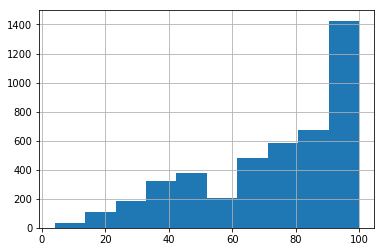

In [69]:
df_results.score.hist()

In [73]:
df_results[df_results.score>=60].sort_values('score').head()

med_desc    rxcui  score  rank
2881  ONABOTULINUMTOXINA 50 UNIT INTRAMUSCULAR SOLUTION  1726292   60.0   1.0
2147  ZOLEDRONIC ACID 5 MG/100 ML IN MANNITOL 5 % AN...   705824   60.0   1.0
506                           DORZOLAMIDE 2 % EYE DROPS   310015   60.0   1.0
1972                          AMPICILLIN IN 100 ML IVPB   315375   60.0   1.0
3305           DOBUTAMINE INFUSION 1 MG/ML IN 0.9% NACL   242816   60.0   1.0

In [74]:
rxnorm_req('approximateTerm', term='ONABOTULINUMTOXINA 50 UNIT INTRAMUSCULAR SOLUTION',
           maxEntries=4, option=1)

{'approximateGroup': {'inputTerm': 'ONABOTULINUMTOXINA 50 UNIT INTRAMUSCULAR SOLUTION',
  'maxEntries': '4',
  'option': '1',
  'comment': None,
  'candidate': [{'rxcui': '1726292',
    'rxaui': '7715603',
    'score': '60',
    'rank': '1'}]}}

In [78]:
df_results_ext = df_results.rxcui.apply(get_props_df)

In [82]:
df_results = df_results.merge(df_results_ext, how='left', left_index=True, right_index=True)

In [118]:
df_results.head()

med_desc  rxcui_x  score  rank  \
0   INSULIN ASPART 100 UNIT/ML SUBCUTANEOUS SOLUTION   311040   75.0   1.0   
1  HEPARIN, PORCINE (PF) 5,000 UNIT/0.5 ML INJECT...  1361853   80.0   1.0   
2                     DOCUSATE SODIUM 100 MG CAPSULE  1115005  100.0   1.0   
3                        ACETAMINOPHEN 325 MG TABLET   313782  100.0   1.0   
4           HYDROMORPHONE 2 MG/ML INJECTION SOLUTION   897745  100.0   1.0   

                                              rxname  rxcui_y  \
0  Insulin, Aspart, Human 100 UNT/ML Injectable S...   311040   
1  0.5 ML heparin sodium, porcine 10000 UNT/ML Ca...  1361853   
2                Docusate Sodium 100 MG Oral Capsule  1115005   
3                   Acetaminophen 325 MG Oral Tablet   313782   
4  Hydromorphone Hydrochloride 2 MG/ML Injectable...   897745   

                                               rxsyn rxtty  mo_code  
0  Insulin analog, Aspart 100 UNT/ML Injectable S...   SCD   311040  
1  heparin sodium, porcine 5000 UNT per 0.5 ML Ca...   SCD  1361853  
2                    DOSS Sodium 100 MG Oral Capsule   SCD  1115005  
3                            APAP 325 MG Oral Tablet   SCD   313782  
4      hydromorphone HCl 2 MG/ML Injectable Solution   SCD   897745

In [88]:
df_results.rxtty.fillna('N/A').value_counts()

SCD     3376
N/A      415
IN       312
SCDC     251
SBD      242
PIN       58
SCDF      42
SBDC      21
BN        21
GPCK      19
MIN       14
SCDG      11
SBDF       8
BPCK       4
SBDG       4
DF         2
Name: rxtty, dtype: int64

In [91]:
df_admins_excs.head()

VISIT_ID  ADMIT_DATE MED_ORDER_ID   AdministrationNumber       StartDate  \
0  1089467295  2017030100    108884945   11896163-108884945-5  20170305082200   
1  1089467295  2017030100    108884945  11896163-108884945-18  20170309090600   
2  1090637128  2017030319    108933652   11923854-108933652-7  20170305143100   
3  1090637128  2017030319    108933652  11923854-108933652-26  20170309201500   
4  1091002757  2017030919    109353760   11965519-109353760-1  20170310123000   

  MED_CODE                                           MED_DESC  
0      250  ALBUTEROL SULFATE 2.5 MG/3 ML (0.083 %) SOLUTI...  
1      250  ALBUTEROL SULFATE 2.5 MG/3 ML (0.083 %) SOLUTI...  
2      250  ALBUTEROL SULFATE 2.5 MG/3 ML (0.083 %) SOLUTI...  
3      250  ALBUTEROL SULFATE 2.5 MG/3 ML (0.083 %) SOLUTI...  
4      250  albuterol 0.083 % (PROVENTIL) 2.5 mg /3 mL (0....

In [94]:
df_admin_excs_resolved = df_admins_excs.merge(df_results, how='left', left_on='MED_DESC', right_on='med_desc')

In [95]:
df_admin_excs_resolved.head(1).T

0
VISIT_ID                                                     1089467295
ADMIT_DATE                                                   2017030100
MED_ORDER_ID                                                  108884945
AdministrationNumber                               11896163-108884945-5
StartDate                                                20170305082200
MED_CODE                                                            250
MED_DESC              ALBUTEROL SULFATE 2.5 MG/3 ML (0.083 %) SOLUTI...
med_desc              ALBUTEROL SULFATE 2.5 MG/3 ML (0.083 %) SOLUTI...
rxcui_x                                                          630208
score                                                                82
rank                                                                  1
rxname                           Albuterol 0.83 MG/ML Inhalant Solution
rxcui_y                                                          630208
rxsyn                               albuterol 0.083 % Inhalant Solution
rxtty                                                               SCD
mo_code                                                          630208

In [107]:
df_admin_excs_resolved[df_admin_excs_resolved.score<40].sort_values('score', ascending=False).head()[['med_desc','rxsyn']].iloc[0]

med_desc            DEXMEDTOMIDINE INFUSION IN 100 ML (ADULT)
rxsyn       dexmedetomidine (as dexmedetomidine HCl) 100 M...
Name: 4331133, dtype: object

In [100]:
df_omop_drugs[df_omop_drugs.SRC_CODE=='410898'].head()

DRUG_SOURCE_VALUE SRC_CODE              CONCEPT_NAME  \
293   urn:hssc:musc:medicationcode|410898   410898  Inpatient administration   
4492  urn:hssc:musc:medicationcode|410898   410898      Prescription written   

     CONCEPT_CLASS_ID RXCUI  N_RECS  P_RECS_BY_TYPE  P_RECS_OF_ALL  
293              None  None     632           0.069         0.0257  
4492             None  None     320           0.021         0.0130

In [135]:
s_ambs = df_results.groupby(['mo_code']).rxcui_x.nunique()

In [136]:
ambiguous_codes = s_ambs[s_ambs>1].index.values

In [137]:
df_results[df_results.mo_code.isin(ambiguous_codes)].sort_values('mo_code')

Empty DataFrame
Columns: [med_desc, rxcui_x, score, rank, rxname, rxcui_y, rxsyn, rxtty, mo_code]
Index: []

In [166]:
cols_for_map = ['MED_CODE', 'rxcui_x', 'score']
df_map = df_admin_excs_resolved[cols_for_map].drop_duplicates().sort_values('score')
scores_high_enough = df_map.score>=50
df_map = ( df_map
           .loc[scores_high_enough,cols_for_map]
           .drop_duplicates(subset=['MED_CODE'], keep='last')
         )

In [167]:
df_map.head()

MED_CODE rxcui_x  score
24201   400133    3251   50.0
20578   410021   12574   50.0
24728   410009    3002   50.0
24727   410000    4492   50.0
24721   400436  203164   50.0

In [168]:
df_map.MED_CODE.nunique()

3252

In [171]:
df_map[df_map.MED_CODE.str.len()>8]

MED_CODE  rxcui_x  score
21405  1151546152  1094833   50.0
96626  1154100161   996051   50.0

In [185]:
df_map.columns = ['src_code', 'rxcui', 'score']
df_map['cval'] = df_map.src_code.apply(lambda x: 'urn:hssc:musc:medicationcode|%s'%x)
df_map = df_map[['src_code', 'cval', 'rxcui']]
df_map.head()

src_code                                 cval   rxcui
24201   400133  urn:hssc:musc:medicationcode|400133    3251
20578   410021  urn:hssc:musc:medicationcode|410021   12574
24728   410009  urn:hssc:musc:medicationcode|410009    3002
24727   410000  urn:hssc:musc:medicationcode|410000    4492
24721   400436  urn:hssc:musc:medicationcode|400436  203164

In [186]:
df_map.to_csv('admin_code_map_from_desc.csv', sep='|', index=False)

In [197]:
df_omop_drugs[(not_fully_specd|not_mapped)]

DRUG_SOURCE_VALUE      SRC_CODE  \
8      urn:hssc:musc:medicationcode|118222        118222   
28     urn:hssc:musc:medicationcode|159131        159131   
29     urn:hssc:musc:medicationcode|600864        600864   
36      urn:hssc:musc:medicationcode|10323         10323   
43     urn:hssc:musc:medicationcode|600897        600897   
63       urn:hssc:musc:medicationcode|5245          5245   
68     urn:hssc:musc:medicationcode|195847        195847   
84     urn:hssc:musc:medicationcode|410106        410106   
90     urn:hssc:musc:medicationcode|115575        115575   
91      urn:hssc:musc:medicationcode|41137         41137   
99     urn:hssc:musc:medicationcode|430032        430032   
106    urn:hssc:musc:medicationcode|600132        600132   
115    urn:hssc:musc:medicationcode|119770        119770   
119    urn:hssc:musc:medicationcode|410102        410102   
133    urn:hssc:musc:medicationcode|118702        118702   
137     urn:hssc:musc:medicationcode|37930         37930   
144    urn:hssc:musc:medicationcode|120027        120027   
150     urn:hssc:musc:medicationcode|70284         70284   
164    urn:hssc:musc:medicationcode|117965        117965   
182    urn:hssc:musc:medicationcode|430153        430153   
186    urn:hssc:musc:medicationcode|400470        400470   
188    urn:hssc:musc:medicationcode|410147        410147   
201    urn:hssc:musc:medicationcode|400048        400048   
206    urn:hssc:musc:medicationcode|410091        410091   
213     urn:hssc:musc:medicationcode|38978         38978   
214    urn:hssc:musc:medicationcode|119764        119764   
215    urn:hssc:musc:medicationcode|600098        600098   
217    urn:hssc:musc:medicationcode|115673        115673   
224    urn:hssc:musc:medicationcode|600432        600432   
227      urn:hssc:musc:medicationcode|9801          9801   
...                                    ...           ...   
23688        urn:hssc:musc:ndc|11917-14111   11917-14111   
23689  urn:hssc:musc:medicationcode|165426        165426   
23690  urn:hssc:musc:medicationcode|199345        199345   
23691  urn:hssc:musc:medicationcode|198159        198159   
23693       urn:hssc:musc:ndc|42192-323-30  42192-323-30   
23695  urn:hssc:musc:medicationcode|108964        108964   
23696        urn:hssc:musc:ndc|11845-05421   11845-05421   
23697  urn:hssc:musc:medicationcode|109160        109160   
23698  urn:hssc:musc:medicationcode|133600        133600   
23699       urn:hssc:musc:ndc|54569-1901-1  54569-1901-1   
23700  urn:hssc:musc:medicationcode|178665        178665   
23701       urn:hssc:musc:ndc|51552-0326-3  51552-0326-3   
23703  urn:hssc:musc:medicationcode|197210        197210   
23704       urn:hssc:musc:ndc|38779-0946-1  38779-0946-1   
23705  urn:hssc:musc:medicationcode|126300        126300   
23706  urn:hssc:musc:medicationcode|178228        178228   
23707  urn:hssc:musc:medicationcode|140476        140476   
23708  urn:hssc:musc:medicationcode|195122        195122   
23709  urn:hssc:musc:medicationcode|137740        137740   
23710  urn:hssc:musc:medicationcode|109468        109468   
23712  urn:hssc:musc:medicationcode|122106        122106   
23713  urn:hssc:musc:medicationcode|159947        159947   
23714       urn:hssc:musc:ndc|16590-678-30  16590-678-30   
23715  urn:hssc:musc:medicationcode|134860        134860   
23716  urn:hssc:musc:medicationcode|109050        109050   
23719  urn:hssc:musc:medicationcode|141790        141790   
23721  urn:hssc:musc:medicationcode|128185        128185   
23722  urn:hssc:musc:medicationcode|111684        111684   
23724  urn:hssc:musc:medicationcode|141758        141758   
23725  urn:hssc:musc:medicationcode|194885        194885   

                   CONCEPT_NAME    CONCEPT_CLASS_ID  RXCUI  N_RECS  \
8      Inpatient administration          Ingredient   8163   11085   
28     Inpatient administration                None   None    4675   
29     Inpatient administration          Ingredient  48937    4632   
36     Inpatient adminis

In [202]:
rxnorm_req('approximateTerm', term='PHENYLEPHRINE HCL/0.9% NACL/PF', #PHENYLEPHRINE (PF) 0.8 MG/10 ML (80 MCG/ML) IN 0.9 % NACL IV SYRINGE',
           maxEntries=4)

{'approximateGroup': {'inputTerm': 'PHENYLEPHRINE HCL/0.9% NACL/PF',
  'maxEntries': '4',
  'comment': None,
  'candidate': [{'rxcui': '1666520',
    'rxaui': '5036453',
    'score': '40',
    'rank': '1'},
   {'rxcui': '1945112', 'rxaui': '5036613', 'score': '40', 'rank': '1'}]}}

In [203]:
get_status(1666520)

'Alien'